<a href="https://colab.research.google.com/github/mpolitano/redesNueronales/blob/master/RedesP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
from google.colab import drive
drive.mount('/mnist')

Drive already mounted at /mnist; to attempt to forcibly remount, call drive.mount("/mnist", force_remount=True).


In [74]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch import nn
import os
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import save_image
from tqdm import tqdm
import os
import matplotlib.pyplot as plt


In [75]:
dir_name = '/content/gdrive/My Drive/Colab Notebooks/pytorch/Autoencoder_MNIST_files'
base_model_name = 'hidden{:04}_dropout{:.3f}_batch{:05}_lr{:.6f}_momentum{:.6f}'.format(
    hidden_layer_size, dropout, train_batch_size, learning_rate, momentum
)
model_name = base_model_name + '.pt'
loss_name  = base_model_name + '.txt'

print(model_name)
model_path = os.path.join(dir_name, 'models', model_name)
loss_path = os.path.join(dir_name, 'loss', loss_name)

hidden0512_dropout0.100_batch01000_lr10.000000_momentum0.500000.pt


 conjunto de datos de entrenamiento
 

In [185]:
# n_epochs = 3
input_shape = 28*28
hidden_layer_size = 64

train_batch_size = 1000
test_batch_size = 1000
learning_rate = 10
momentum = 0.5
log_interval = 10

random_seed = 1
torch.manual_seed(random_seed)
dropout = 0.1
n_epochs=15

In [186]:
# mnist_data = datasets.MNIST('./data', train=True, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor()]))
transform = transforms.Compose([transforms.ToTensor()])

    # load the dataset
train_dataset = datasets.MNIST(
    root='./data', train=True,
    download=True, transform=transform,
)

test_dataset = datasets.MNIST(
    root='./data', train=True,
    download=True, transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batch_size, 
    shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=4
)

La squeeze elimina las capaz dummy. Como es blanco y negro, no necesitamos esta capa. Usamos una red fully conecty lineal.

Para el programa una imagen es en 3D pero no sotros queremos en 2D



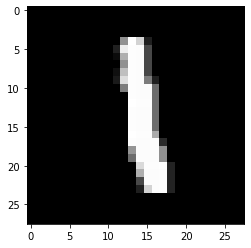

In [77]:
plt.imshow(train_dataset[6][0].numpy().squeeze(), cmap='gray')

imshow me permite graficar un array con forma de imagen
El dataset esta guardado como una lista de dos valores. El 0 es la imagen, el elemento 1 es la imagen

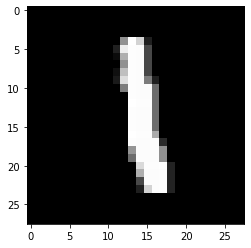

In [49]:
plt.imshow(train_dataset[6][0].numpy().squeeze(), cmap='gray')

 conjunto de datos de test

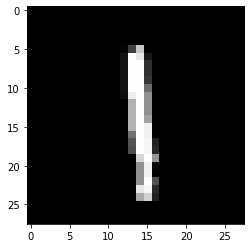

In [53]:
plt.imshow(test_dataset[8][0].numpy().squeeze(), cmap='gray')

In [55]:
print(train_dataset[8][1])

1


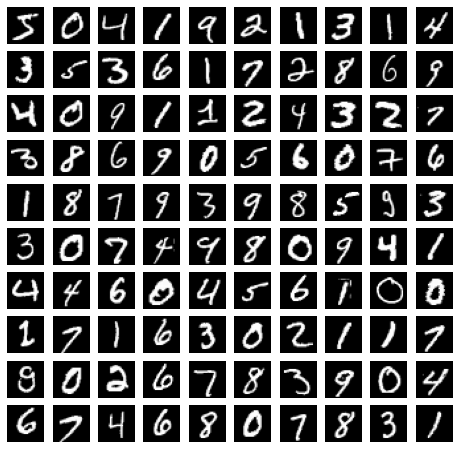

In [56]:
Nshowx = 10
Nshowy = 10
plt.figure(figsize=(8,8))
for i in range(1,Nshowx*Nshowy+1): 
    plt.subplot(Nshowx,Nshowy,i)
    plt.imshow(train_dataset.data[i-1], cmap='gray')
    plt.axis("off")
plt.savefig(os.path.join('ejemplos.pdf'), dpi=300)
plt.show()

In [166]:
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))


In [167]:
np.random.seed(random_seed)
np.random.shuffle(indices)

In [168]:
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [187]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [188]:
class Squeeze(nn.Module):
    def forward(self, inpt):
        return inpt.view(inpt.size(0), 1, 28, 28)

In [18]:
print(dropout)

0.1


In [189]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        # self.autoenc = nn.Sequential()
        self.enco = nn.Linear(input_shape, hidden_layer_size)
        self.deco = nn.Linear(hidden_layer_size, input_shape)

        # self.autoenc.add_module('enc',self.enco)
        # self.autoenc.add_module('dec',self.deco)

        self.relu = nn.ReLU()
        self.flatten = Flatten()
        self.squeeze = Squeeze()
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, x):
          # def forward(self, x):
        # pred = F.relu(self.enco(x))
        # pred = F.relu(self.deco(pred))
        # return pred
        x = self.flatten(x)
        x = self.enco(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.deco(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.squeeze(x)
        return x

In [190]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cpu


Optimizador es el descenso por el gradiente. Ver de usar Adam

In [191]:
network = autoencoder().to(device)
optimizer = torch.optim.Adam(network.parameters(), weight_decay=1e-5)

In [192]:
# Mean Squared Error Loss
criterion = nn.MSELoss()

In [193]:
flatten = Flatten()

In [194]:
train_loss_values = []
test_loss_values  = []

In [195]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
train_losses = []


In [196]:


for epoch in range(n_epochs):
    loss = 0
    for batch_features, _ in train_loader:

        # load it to the active device
        batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = network(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    avg_train_loss = loss / len(train_loader)

    train_loss_values.append(avg_train_loss)

    with torch.no_grad():
        loss = 0
        for batch_features, _ in test_loader:

            # load it to the active device
            batch_features = batch_features.to(device)
            
            # compute reconstructions
            outputs = network(batch_features)
            
            # compute testing reconstruction loss
            test_loss = criterion(outputs, batch_features)
                        
            # add the mini-batch testing loss to epoch loss
            loss += test_loss.item()
    
    # compute the epoch testing loss
    avg_test_loss = loss / len(test_loader)

    test_loss_values.append(avg_test_loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, train loss = {:.6f}, test loss = {:.6f}, ".format(
        epoch + 1, n_epochs, avg_train_loss, avg_test_loss)
    )

epoch : 1/15, train loss = 0.070972, test loss = 0.052713, 
epoch : 2/15, train loss = 0.045914, test loss = 0.040796, 
epoch : 3/15, train loss = 0.038071, test loss = 0.035756, 
epoch : 4/15, train loss = 0.034337, test loss = 0.033089, 
epoch : 5/15, train loss = 0.032077, test loss = 0.031117, 
epoch : 6/15, train loss = 0.030587, test loss = 0.029898, 
epoch : 7/15, train loss = 0.029375, test loss = 0.028883, 
epoch : 8/15, train loss = 0.028697, test loss = 0.028404, 
epoch : 9/15, train loss = 0.028165, test loss = 0.027949, 
epoch : 10/15, train loss = 0.027867, test loss = 0.027768, 
epoch : 11/15, train loss = 0.027631, test loss = 0.027521, 
epoch : 12/15, train loss = 0.027473, test loss = 0.027391, 
epoch : 13/15, train loss = 0.027195, test loss = 0.026993, 
epoch : 14/15, train loss = 0.026933, test loss = 0.026797, 
epoch : 15/15, train loss = 0.026749, test loss = 0.026616, 


In [197]:
torch.save(network.state_dict(), str(hidden_layer_size))
np.savetxt(str(hidden_layer_size), np.array([train_loss_values, test_loss_values]).T)

In [198]:
hidden_layer_size

64

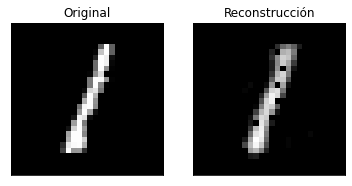

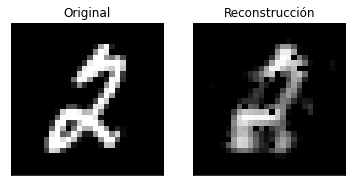

In [91]:
def compare(dataset, n=None):

  if not n:
    n = np.random.randint(dataset.data.size(0))
  inpt = dataset[n][0]

  original = inpt.detach().numpy().squeeze()
  autoencoded = network(inpt).detach().numpy().squeeze()

  titles = ['Original', 'Reconstrucción']

  fig, axes = plt.subplots(ncols=2)

  for i, img in enumerate([original, autoencoded]):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i])
    ax.imshow(img, cmap='gray')

compare(train_dataset)
compare(test_dataset)

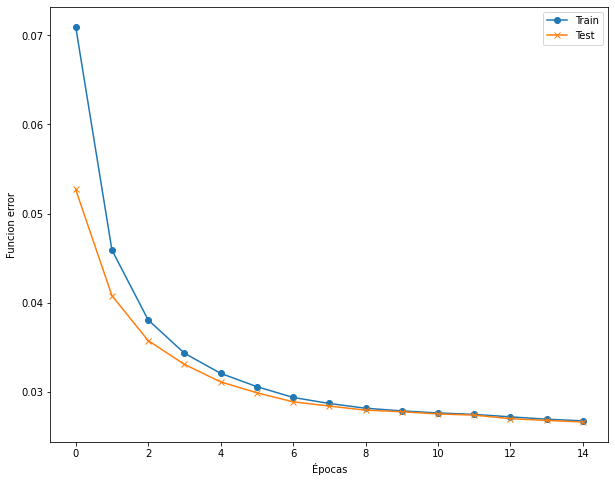

In [199]:
epochs = np.arange(len(train_loss_values))

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_ylabel('Funcion error')
ax.set_xlabel('Épocas')

ax.plot(epochs, np.array(train_loss_values), 'o-', label='Train')
ax.plot(epochs, np.array(test_loss_values), 'x-', label='Test')

ax.legend()

plt.savefig( "Train-vs-test.png")

plt.show()

In [ ]:
dir_name = '/content/gdrive/My Drive/Colab Notebooks/pytorch/Autoencoder_MNIST_files'
base_model_name = 'hidden{:04}_dropout{:.3f}_batch{:05}_lr{:.6f}_momentum{:.6f}'.format(
    hidden_layer_size, dropout, train_batch_size, learning_rate, momentum
)
model_name = base_model_name + '.pt'
loss_name  = base_model_name + '.txt'

print(model_name)
model_path = os.path.join(dir_name, 'models', model_name)
loss_path = os.path.join(dir_name, 'loss', loss_name)


In [181]:
train_loss_dict = {}
test_loss_dict = {}

hidden_values = [64,128,256,512]

for hidden in hidden_values:

    inpt_file_name = 'hidden{:04}_dropout{:.3f}_batch{:05}_lr{:.6f}_momentum{:.6f}'.format(
        hidden, dropout, train_batch_size, learning_rate, momentum
    )
    train_loss, test_loss = np.loadtxt(str(hidden)).T

    train_loss_dict[hidden] = train_loss
    test_loss_dict[hidden] = test_loss

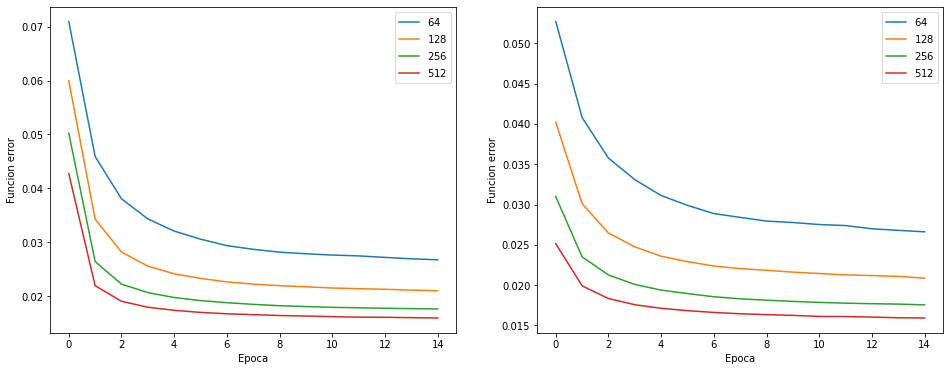

In [184]:

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for hidden in hidden_values:
    train_loss, test_loss = train_loss_dict[hidden], test_loss_dict[hidden]
    for i, loss_values in enumerate([train_loss, test_loss]):
        ax = axes[i]
        epochs = np.arange(train_loss.shape[0])
        ax.plot(epochs, loss_values, label=r'${{{}}}$'.format(hidden))

for ax in axes:
    ax.set_ylabel('Funcion error')
    ax.set_xlabel('Epoca')
    ax.legend()

plt.show()

Ejemplo de la clase:


In [ ]:
def train(epoch):
    loss_items = 0
    # network.train()
    crossent = nn.MSELoss() #La salida no es una clase.
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = crossent(output, flatten(data))
        loss.backward()
        optimizer.step()

        loss_items += loss.item()
        loss_items_avg = loss_items / len(train_loader)
        train_counter.append(loss_items_avg)

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),loss_items_avg))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [ ]:
def test():
    crossent = nn.MSELoss()
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += crossent(output, flatten(data)).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

In [ ]:
network.eval()

In [ ]:
plt.imshow(flatten(mnist_test[1][0]).reshape([28,28]), cmap='gray')